In [ ]:
pip install pandas numpy torch transformers datasets scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, DistilBertTokenizer, RobertaTokenizer, AlbertTokenizer, XLNetTokenizer
from transformers import BertForSequenceClassification, DistilBertForSequenceClassification, RobertaForSequenceClassification, AlbertForSequenceClassification, XLNetForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset
#import fitz
from google.colab import files
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler



In [ ]:
from google.colab import files


uploaded = files.upload()

Saving UpdatedResumeDataSet.csv to UpdatedResumeDataSet.csv


In [ ]:
import pandas as pd
import io

data = pd.read_csv(io.BytesIO(uploaded['UpdatedResumeDataSet.csv']))
data.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [ ]:
import re
data['Resume'] = data['Resume'].apply(lambda x: re.sub(r'[^A-Za-z0-9\s]+', '', x))
# Convert categories to numerical labels
data['category'] = pd.factorize(data['Category'])[0]
category_map = {index: label for index, label in enumerate(data['Category'].unique())}

# Tokenizer (choosing tokenizer based on the model type)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
albert_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
xlnet_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

def tokenize_function(examples):
    return bert_tokenizer(examples['Resume'], padding="max_length", truncation=True)


In [ ]:
# Step 3: Prepare Dataset for PyTorch
dataset = Dataset.from_pandas(data[['Resume', 'category']])
tokenized_data = dataset.map(tokenize_function, batched=True)

# Set up the format for PyTorch
tokenized_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'category'], output_all_columns=True)

# Rename "category" to "labels" since Trainer expects labels for calculating the loss
tokenized_data = tokenized_data.rename_column("category", "labels")

# Split dataset into train and test
train_test_data = tokenized_data.train_test_split(test_size=0.2)
train_data = train_test_data['train']
test_data = train_test_data['test']


Map:   0%|          | 0/962 [00:00<?, ? examples/s]

In [ ]:
# Define custom metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


In [ ]:
# BERT Model
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(category_map))
bert_training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",  # Updated parameter name
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',  # Directory for logs
    logging_steps=10,
    report_to="none"  # Disables Weights & Biases logging
)

# Trainer for BERT
bert_trainer = Trainer(
    model=bert_model,
    args=bert_training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics
)

# Train BERT
print("Training BERT model...")
bert_trainer.train()
bert_metrics = bert_trainer.evaluate()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training BERT model...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.844300,2.736761,0.347150,0.259426,0.295849,0.347150
2,2.399900,2.221233,0.678756,0.608198,0.618556,0.678756
3,2.032100,1.829739,0.803109,0.768226,0.826660,0.803109
4,1.761300,1.615872,0.849741,0.828616,0.880869,0.849741
5,1.684700,1.548175,0.860104,0.838199,0.885005,0.860104


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# DistilBERT Model
distilbert_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(category_map))
distilbert_training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',  # Directory for logs
    logging_steps=10,
    report_to="none"
)

# Trainer for DistilBERT
distilbert_trainer = Trainer(
    model=distilbert_model,
    args=distilbert_training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics
)

# Train DistilBERT
print("Training DistilBERT model...")
distilbert_trainer.train()
distilbert_metrics = distilbert_trainer.evaluate()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training DistilBERT model...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,3.047900,3.006270,0.155440,0.106698,0.126022,0.155440
2,2.680700,2.614676,0.435233,0.350558,0.411835,0.435233
3,2.355000,2.289625,0.632124,0.561604,0.632228,0.632124
4,2.083700,2.085509,0.740933,0.696534,0.764545,0.740933
5,2.045700,2.011489,0.803109,0.764767,0.812246,0.803109


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(category_map))
roberta_training_args = TrainingArguments(
    output_dir='./results_roberta',
    eval_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',  # Directory for logs
    logging_steps=10,
    report_to="none"
)

# Trainer for roberta
roberta_trainer = Trainer(
    model=roberta_model,
    args=roberta_training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics
)

# Train roberta
print("Training roberta model...")
roberta_trainer.train()
roberta_metrics = roberta_trainer.evaluate()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training roberta model...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,3.135300,3.040073,0.129534,0.052266,0.042089,0.129534
2,2.901500,2.761867,0.243523,0.152139,0.151135,0.243523
3,2.525500,2.369459,0.409326,0.315260,0.334436,0.409326
4,2.199200,2.122040,0.497409,0.408205,0.440504,0.497409
5,2.156500,1.975175,0.621762,0.516472,0.468196,0.621762


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
albert_model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=len(category_map))
albert_training_args = TrainingArguments(
    output_dir='./results_albert',
    eval_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',  # Directory for logs
    logging_steps=10,
    report_to="none"
)
# Trainer for roberta
albert_trainer = Trainer(
    model=albert_model,
    args=albert_training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics
)

# Train Albert
print("Training albert model...")
albert_trainer.train()
albert_metrics = albert_trainer.evaluate()

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training albert model...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,3.170700,3.112475,0.139896,0.053918,0.060221,0.139896
2,3.007000,2.956068,0.165803,0.052970,0.031955,0.165803
3,2.828600,2.840473,0.243523,0.135494,0.101206,0.243523
4,2.565800,2.620397,0.331606,0.236279,0.339938,0.331606
5,2.481100,2.506832,0.373057,0.271092,0.276457,0.373057


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from transformers import TrainingArguments, Trainer
import matplotlib.pyplot as plt


In [ ]:
bert_loss_values = bert_trainer.state.log_history
distilbert_loss_values = distilbert_trainer.state.log_history
roberta_loss_values = roberta_trainer.state.log_history
albert_loss_values = albert_trainer.state.log_history


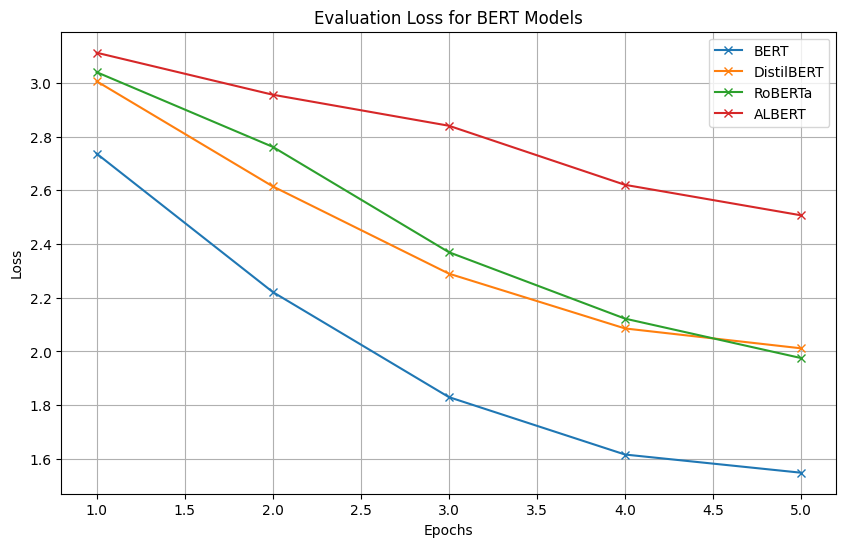

In [ ]:
epochs = range(1, 6)  # Adjust based on `num_train_epochs`

# Plot training and evaluation loss for each model
plt.figure(figsize=(10, 6))

# BERT
#plt.plot(epochs, bert_train_loss[:len(epochs)], label='BERT Train Loss', marker='o')
plt.plot(epochs, bert_eval_loss[:len(epochs)], label='BERT', marker='x')

# DistilBERT
#plt.plot(epochs, distilbert_train_loss[:len(epochs)], label='DistilBERT Train Loss', marker='o')
plt.plot(epochs, distilbert_eval_loss[:len(epochs)], label='DistilBERT', marker='x')

# RoBERTa
#plt.plot(epochs, roberta_train_loss[:len(epochs)], label='RoBERTa Train Loss', marker='o')
plt.plot(epochs, roberta_eval_loss[:len(epochs)], label='RoBERTa', marker='x')

# ALBERT
#plt.plot(epochs, albert_train_loss[:len(epochs)], label='ALBERT Train Loss', marker='o')
plt.plot(epochs, albert_eval_loss[:len(epochs)], label='ALBERT', marker='x')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evaluation Loss for BERT Models')
plt.legend()
plt.grid()
plt.show()

In [ ]:
def extract_loss_values(log_history):
    training_loss = [log["loss"] for log in log_history if "loss" in log]
    eval_loss = [log["eval_loss"] for log in log_history if "eval_loss" in log]
    return training_loss, eval_loss

bert_train_loss, bert_eval_loss = extract_loss_values(bert_loss_values)
distilbert_train_loss, distilbert_eval_loss = extract_loss_values(distilbert_loss_values)
roberta_train_loss, roberta_eval_loss = extract_loss_values(roberta_loss_values)
albert_train_loss, albert_eval_loss = extract_loss_values(albert_loss_values)


In [ ]:
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}


In [ ]:
def extract_accuracy_values(log_history):
    accuracy = [log["eval_accuracy"] for log in log_history if "eval_accuracy" in log]
    return accuracy

bert_accuracy = extract_accuracy_values(bert_trainer.state.log_history)
distilbert_accuracy = extract_accuracy_values(distilbert_trainer.state.log_history)
roberta_accuracy = extract_accuracy_values(roberta_trainer.state.log_history)
albert_accuracy = extract_accuracy_values(albert_trainer.state.log_history)


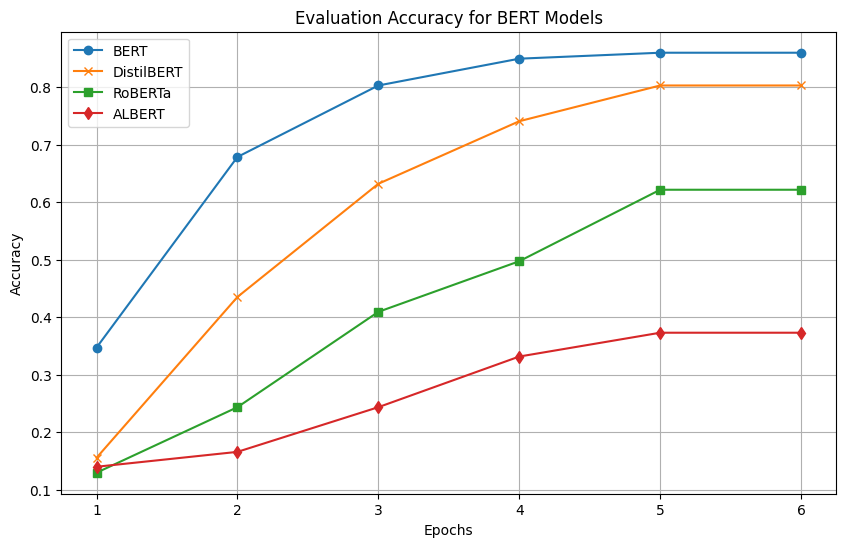

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(bert_accuracy) + 1)  # Adjust based on the length of accuracy logs

# Plot evaluation accuracy for each model
plt.figure(figsize=(10, 6))

# BERT
plt.plot(epochs, bert_accuracy, label='BERT', marker='o')

# DistilBERT
plt.plot(epochs, distilbert_accuracy, label='DistilBERT', marker='x')

# RoBERTa
plt.plot(epochs, roberta_accuracy, label='RoBERTa', marker='s')

# ALBERT
plt.plot(epochs, albert_accuracy, label='ALBERT', marker='d')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy for BERT Models')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Step 5: Compare Models
print("BERT metrics:", bert_metrics)
print("DistilBERT metrics:", distilbert_metrics)
print("RoBERTa metrics:", roberta_metrics)
print("ALBERT metrics:" ,albert_metrics)
#print( "XLNet metrics:" xlnet_metrics)

best_model = bert_model if bert_metrics['eval_accuracy'] > distilbert_metrics['eval_accuracy'] else distilbert_model
best_tokenizer = bert_tokenizer if bert_metrics['eval_accuracy'] > distilbert_metrics['eval_accuracy'] else distilbert_tokenizer


BERT metrics: {'eval_loss': 1.548174500465393, 'eval_accuracy': 0.8601036269430051, 'eval_f1': 0.8381986048860521, 'eval_precision': 0.8850050834963971, 'eval_recall': 0.8601036269430051, 'eval_runtime': 5.7604, 'eval_samples_per_second': 33.505, 'eval_steps_per_second': 4.34, 'epoch': 5.0}
DistilBERT metrics: {'eval_loss': 2.011489152908325, 'eval_accuracy': 0.8031088082901554, 'eval_f1': 0.7647671070576381, 'eval_precision': 0.8122464934317265, 'eval_recall': 0.8031088082901554, 'eval_runtime': 2.785, 'eval_samples_per_second': 69.301, 'eval_steps_per_second': 8.977, 'epoch': 5.0}
RoBERTa metrics: {'eval_loss': 1.9751745462417603, 'eval_accuracy': 0.6217616580310881, 'eval_f1': 0.516472187382683, 'eval_precision': 0.4681959830309981, 'eval_recall': 0.6217616580310881, 'eval_runtime': 5.8641, 'eval_samples_per_second': 32.912, 'eval_steps_per_second': 4.263, 'epoch': 5.0}
ALBERT metrics: {'eval_loss': 2.5068323612213135, 'eval_accuracy': 0.37305699481865284, 'eval_f1': 0.2710922772879

In [ ]:
# Step 6: Predict Category of New Resume
def predict_job_role(resume_text):
    inputs = best_tokenizer(resume_text, return_tensors="pt", padding=True, truncation=True)
    inputs = {key: value.to('cuda') for key, value in inputs.items()}  # Send inputs to GPU if available
    best_model.to('cuda')  # Send model to GPU if available
    outputs = best_model(**inputs)
    pred = outputs.logits.argmax(dim=1).item()
    return category_map[pred]

In [ ]:
# Example usage
sample_resume = "Experienced software developer with expertise in Python, machine learning, and data science."
predicted_category = predict_job_role(sample_resume)
print("Predicted Job Role Category:", predicted_category)

Predicted Job Role Category: HR


In [ ]:
import fitz  # PyMuPDF
from transformers import BertTokenizer, Trainer
from google.colab import files  # Only for Google Colab; adjust for other platforms

# Function to extract text from PDF
def extract_text_from_pdf(pdf_path):
    text = ""
    with fitz.open(pdf_path) as pdf:
        for page_num in range(pdf.page_count):
            page = pdf[page_num]
            text += page.get_text()
    return text

# Function to predict job role category for extracted resume text
def predict_job_role(text):
    inputs = best_tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    inputs = {key: value.to('cuda') for key, value in inputs.items()}
    best_model.to('cuda')
    outputs = best_model(**inputs)
    pred = outputs.logits.argmax(dim=1).item()
    return category_map[pred]

# Function to process a single uploaded resume
def process_single_resume():
    # Upload one PDF file
    uploaded_files = files.upload()  # Opens file upload dialog

    # Check that a file is uploaded
    if not uploaded_files:
        print("No file uploaded.")
        return

    # Process the first uploaded file only
    file_name, file_content = next(iter(uploaded_files.items()))

    # Write the uploaded file content to a temporary PDF
    with open(file_name, 'wb') as f:
        f.write(file_content)

    # Extract text from the PDF
    resume_text = extract_text_from_pdf(file_name)

    # Predict the job role category
    predicted_category = predict_job_role(resume_text)

    # Prepare the output list
    resume_info = [predicted_category, file_name, resume_text]

    return resume_info





In [ ]:
text_dict={}
role_dict={}
n=int(input("N.o of resumes to be short listed:"))
for i in range (0,n):
  resume_info = process_single_resume()
  print("Output:", resume_info)
  if resume_info[0] in role_dict:
    role_dict[resume_info[0]].append(resume_info[1])
  else:
    role_dict[resume_info[0]]=[resume_info[1]]
  text_dict[resume_info[1]]=resume_info[2]

N.o of resumes to be short listed:2


Saving jr-human-resources-generalist-resume-example.pdf to jr-human-resources-generalist-resume-example (1).pdf
Output: ['HR', 'jr-human-resources-generalist-resume-example (1).pdf', "KAMARI ASARI-\nDOKUBO\nJr. Human Resources\nGeneralist\nKam_kubo@email.com\n(123) 456-7890\nFremont, CA\nLinkedIn\nTwitter\nGitHub\nEDUCATION\nBachelor of Arts\nHuman Resources\nUniversity of California San\nFrancisco\n2017 - 2021\nSan Francisco, CA\nAwards\nDean's List\nSKILLS\nRecruiting\nLegal Terms\nContract Negotiations\nHR Software (including Zenefits,\nand BambooHR)\nBenefits Packages\nPublic Speaking\nInterviews\nCERTIFICATIONS\nFoundations of Human\nResources Management\nCertificate\nHOBBIES &\nINTERESTS\nCaptain of the Soccer Social Club\nUCSF Debate Team\nCAREER OBJECTIVE\nJr. Human Resources Generalist with 1+ years of experience at Bay Area\nTraffic Solutions, seeking opportunity to continue driving down staff\nturnover by hiring qualified, motivated employees\xa0for the company.\nWORK EXPERI

Saving senior-data-scientist-resume-example.pdf to senior-data-scientist-resume-example (2).pdf
Output: ['Python Developer', 'senior-data-scientist-resume-example (2).pdf', "Terrence\xa0Coleman\ntcoleman@email.com\n(123) 456-7890\nBrooklyn, NY\nLinkedIn\nAnalytically minded self-starter with a decade of experience collaborating with cross-functional teams and\nensuring the accuracy and integrity around data and actionable insights. Prepared to lead teams and interns in\npredictive modeling and insight reporting to boost Hyphen's business efficiency, strategic goals, and profit.\nWORK EXPERIENCE\nBest Buy - Senior Data Scientist\nOctober 2018 - current\nRemote\n· Led data extraction and evaluation efforts to save Best Buy more than 11M over the course of tenure\n· Partnered with product team to build a production recommendation engine in Python that improved the\naverage length on page for users and resulted in $450K in incremental annual revenue\n· Created a customer attrition random f

In [ ]:
print(text_dict)
print(role_dict)

{'jr-human-resources-generalist-resume-example (1).pdf': "KAMARI ASARI-\nDOKUBO\nJr. Human Resources\nGeneralist\nKam_kubo@email.com\n(123) 456-7890\nFremont, CA\nLinkedIn\nTwitter\nGitHub\nEDUCATION\nBachelor of Arts\nHuman Resources\nUniversity of California San\nFrancisco\n2017 - 2021\nSan Francisco, CA\nAwards\nDean's List\nSKILLS\nRecruiting\nLegal Terms\nContract Negotiations\nHR Software (including Zenefits,\nand BambooHR)\nBenefits Packages\nPublic Speaking\nInterviews\nCERTIFICATIONS\nFoundations of Human\nResources Management\nCertificate\nHOBBIES &\nINTERESTS\nCaptain of the Soccer Social Club\nUCSF Debate Team\nCAREER OBJECTIVE\nJr. Human Resources Generalist with 1+ years of experience at Bay Area\nTraffic Solutions, seeking opportunity to continue driving down staff\nturnover by hiring qualified, motivated employees\xa0for the company.\nWORK EXPERIENCE\nHR Generalist\nBay Area Traffic Solutions\nMay 2021 - current\nFremont, CA\nHandled new talent acquisition and recruitme